In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-1.csv


In [ ]:
!pip install pandas numpy scikit-learn torch transformers tqdm


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm


In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with your actual dataset path
df = pd.read_csv('/kaggle/input/train-1.csv')  # Ensure the file path is correct

# Display basic information
print(f"Total samples: {len(df)}")
#df=df[0:10000]
print(df.head())
print(df.shape)

Total samples: 235480
                                                text  Y  Unnamed: 2  \
0  love this licorice it is very soft tasty best ...  1         NaN   
1  the emerald peanuts are so good very crunchy f...  1         NaN   
2  i have been using extra virgin coconut oil for...  1         NaN   
3  i was about to purchase wellness for puppies b...  1         NaN   
4  my two college kids love strawberries and they...  1         NaN   

  Unnamed: 3  Unnamed: 4  
0        NaN         NaN  
1        NaN         NaN  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN  
(235480, 5)


/tmp/ipykernel_30/113994699.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/train-1.csv')  # Ensure the file path is correct


In [ ]:
x, xt, y, yt = train_test_split(
    df['text'].values,
    df['Y'].values,
    test_size=0.9,
    random_state=15,
    stratify=df['Y'].values
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=40,
    #stratify=df['y'].values
)


In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
MAX_LEN = 128

def tokenize_texts(texts, tokenizer, max_len):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Tokenize training and validation texts
train_encodings = tokenize_texts(train_texts, tokenizer, MAX_LEN)
val_encodings = tokenize_texts(val_texts, tokenizer, MAX_LEN)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create Dataset objects
train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class DoubleBERT(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=2):
        super(DoubleBERT, self).__init__()
        # First BERT model for embeddings
        self.bert_encoder = BertModel.from_pretrained(bert_model_name)

        # Second BERT model for classification
        self.bert_classifier = BertModel.from_pretrained(bert_model_name)

        # Classification layer
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert_classifier.config.hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        # Pass through the first BERT encoder
        encoder_outputs = self.bert_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        encoder_cls = encoder_outputs.last_hidden_state[:,0,:]  # CLS token

        # Pass through the second BERT classifier
        classifier_outputs = self.bert_classifier(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        classifier_cls = classifier_outputs.last_hidden_state[:,0,:]  # CLS token

        # Concatenate CLS tokens from both BERTs
        combined = torch.cat((encoder_cls, classifier_cls), dim=1)
        combined = self.dropout(combined)

        # Final classification layer
        logits = self.classifier(combined)

        return logits


In [ ]:

# Check for GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Initialize the model
model = DoubleBERT()
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Define number of training steps
epochs = 10
total_steps = len(train_loader) * epochs

# Define scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function
criterion = nn.CrossEntropyLoss()


Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

def eval_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, preds)
    report = classification_report(true_labels, preds, digits=4)
    return avg_loss, accuracy, report


In [ ]:
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 20)

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, criterion)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss, val_accuracy, val_report = eval_model(model, val_loader, device, criterion)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(val_report)



Epoch 1/range(1, 11)
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0003


Evaluating: 100%|██████████| 148/148 [00:59<00:00,  2.50it/s]


Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0     0.8876    0.9049    0.8962      2103
           1     0.9221    0.9076    0.9147      2607

    accuracy                         0.9064      4710
   macro avg     0.9048    0.9062    0.9055      4710
weighted avg     0.9067    0.9064    0.9065      4710


Epoch 2/range(1, 11)
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0003


Evaluating: 100%|██████████| 148/148 [00:59<00:00,  2.51it/s]


Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0     0.8876    0.9049    0.8962      2103
           1     0.9221    0.9076    0.9147      2607

    accuracy                         0.9064      4710
   macro avg     0.9048    0.9062    0.9055      4710
weighted avg     0.9067    0.9064    0.9065      4710


Epoch 3/range(1, 11)
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0003


Evaluating: 100%|██████████| 148/148 [00:59<00:00,  2.51it/s]

Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0     0.8876    0.9049    0.8962      2103
           1     0.9221    0.9076    0.9147      2607

    accuracy                         0.9064      4710
   macro avg     0.9048    0.9062    0.9055      4710
weighted avg     0.9067    0.9064    0.9065      4710



In [ ]:
# Save the model
model_save_path = 'double_bert_sarcasm_detector.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to double_bert_sarcasm_detector.pt


In [ ]:
# To load the model later
model = DoubleBERT()
model.load_state_dict(torch.load('double_bert_sarcasm_detector.pt'))
model.to(device)
model.eval()

# Function to predict sarcasm
def predict_sarcasm(text, model, tokenizer, device, max_len=128):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)

    return prediction.item()

# Example usage
sample_text = "I just love getting stuck in traffic for hours!"
prediction = predict_sarcasm(sample_text, model, tokenizer, device)
label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
print(f"Prediction: {label}")


/tmp/ipykernel_30/3950191898.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('double_bert_sarcasm_detector.pt'))


Prediction: Not Sarcastic


In [ ]:
# Assuming the sarcasm_test_cases list is already defined
sarcasm_test_cases = [
    "Oh great! Another rainy day. Just what I needed!",
    "What a beautiful day!",  # Contextual
    "I can't believe how wonderfully you handled that mess!",
    "Sure, I'll definitely get right on that.",
    "Thanks for the unsolicited advice, I’ll be sure to use it wisely."
]

# Function to predict sarcasm for a list of cases
def test_sarcasm_cases(cases, model, tokenizer, device):
    for idx, text in enumerate(cases):
        prediction = predict_sarcasm(text, model, tokenizer, device)
        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        print(f"Test Case {idx + 1}: '{text}'\nPrediction: {label}\n")

# Test all the sarcasm cases
test_sarcasm_cases(sarcasm_test_cases, model, tokenizer, device)


Test Case 1: 'Oh great! Another rainy day. Just what I needed!'
Prediction: Not Sarcastic

Test Case 2: 'What a beautiful day!'
Prediction: Sarcastic

Test Case 3: 'I can't believe how wonderfully you handled that mess!'
Prediction: Sarcastic

Test Case 4: 'Sure, I'll definitely get right on that.'
Prediction: Sarcastic

Test Case 5: 'Thanks for the unsolicited advice, I’ll be sure to use it wisely.'
Prediction: Sarcastic



In [ ]:
sarcasm_test_cases = [
    # Contextual Understanding
    {"text": "Oh great! Another rainy day. Just what I needed!", "description": "Contextual Understanding"},

    # Linguistic and Cultural Variability
    {"text": "You really nailed that presentation, didn’t you?", "description": "Linguistic and Cultural Variability"},

    # Nuanced Interpretation
    {"text": "I just love waiting in long lines at the DMV. It’s the highlight of my week!", "description": "Nuanced Interpretation"},

    # Ambiguous Statements
    {"text": "Wow, what a fantastic job!", "description": "Ambiguous Statements"},

    # Hyperbole and Exaggeration
    {"text": "I’ve told you a million times to clean your room!", "description": "Hyperbole and Exaggeration"},

    # Slang and Informal Language
    {"text": "That’s just lit, fam!", "description": "Slang and Informal Language"},

    # Cross-Cultural Idioms
    {"text": "It’s raining cats and dogs!", "description": "Cross-Cultural Idioms"},

    # Role of Emotion
    {"text": "I’m sooo happy for you! 😒", "description": "Role of Emotion"}
]

# Function to predict sarcasm for each case and print the result
def test_sarcasm_cases(cases, model, tokenizer, device):
    for idx, case in enumerate(cases):
        text = case["text"]
        description = case["description"]
        prediction = predict_sarcasm(text, model, tokenizer, device)
        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        print(f"Case Study: {description}\nText: '{text}'\nPrediction: {label}\n")

# Test all sarcasm cases
test_sarcasm_cases(sarcasm_test_cases, model, tokenizer, device)


Case Study: Contextual Understanding
Text: 'Oh great! Another rainy day. Just what I needed!'
Prediction: Not Sarcastic

Case Study: Linguistic and Cultural Variability
Text: 'You really nailed that presentation, didn’t you?'
Prediction: Sarcastic

Case Study: Nuanced Interpretation
Text: 'I just love waiting in long lines at the DMV. It’s the highlight of my week!'
Prediction: Sarcastic

Case Study: Ambiguous Statements
Text: 'Wow, what a fantastic job!'
Prediction: Sarcastic

Case Study: Hyperbole and Exaggeration
Text: 'I’ve told you a million times to clean your room!'
Prediction: Not Sarcastic

Case Study: Slang and Informal Language
Text: 'That’s just lit, fam!'
Prediction: Sarcastic

Case Study: Cross-Cultural Idioms
Text: 'It’s raining cats and dogs!'
Prediction: Not Sarcastic

Case Study: Role of Emotion
Text: 'I’m sooo happy for you! 😒'
Prediction: Sarcastic



In [ ]:
sarcasm_test_cases = [
    # Contextual Understanding
    {"text": "Oh great! Another rainy day. Just what I needed!", "description": "Contextual Understanding"},

    # Linguistic and Cultural Variability
    {"text": "You really nailed that presentation, didn’t you?", "description": "Linguistic and Cultural Variability"},

    # Nuanced Interpretation
    {"text": "I just love waiting in long lines at the DMV. It’s the highlight of my week!", "description": "Nuanced Interpretation"},

    # Ambiguous Statements
    {"text": "Wow, what a fantastic job!", "description": "Ambiguous Statements"},

    # Hyperbole and Exaggeration
    {"text": "I’ve told you a million times to clean your room!", "description": "Hyperbole and Exaggeration"},

    # Slang and Informal Language
    {"text": "That’s just lit, fam!", "description": "Slang and Informal Language"},

    # Cross-Cultural Idioms
    {"text": "It’s raining cats and dogs!", "description": "Cross-Cultural Idioms"},

    # Role of Emotion
    {"text": "I’m sooo happy for you! 😒", "description": "Role of Emotion"}
]

# Function to predict sarcasm for each case and print the result
def test_sarcasm_cases(cases, model, tokenizer, device):
    for idx, case in enumerate(cases):
        text = case["text"]
        description = case["description"]
        prediction = predict_sarcasm(text, model, tokenizer, device)
        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        print(f"Case Study: {description}\nText: '{text}'\nPrediction: {label}\n")

# Test all sarcasm cases
test_sarcasm_cases(sarcasm_test_cases, model, tokenizer, device)


Case Study: Contextual Understanding
Text: 'Oh great! Another rainy day. Just what I needed!'
Prediction: Not Sarcastic

Case Study: Linguistic and Cultural Variability
Text: 'You really nailed that presentation, didn’t you?'
Prediction: Sarcastic

Case Study: Nuanced Interpretation
Text: 'I just love waiting in long lines at the DMV. It’s the highlight of my week!'
Prediction: Sarcastic

Case Study: Ambiguous Statements
Text: 'Wow, what a fantastic job!'
Prediction: Sarcastic

Case Study: Hyperbole and Exaggeration
Text: 'I’ve told you a million times to clean your room!'
Prediction: Not Sarcastic

Case Study: Slang and Informal Language
Text: 'That’s just lit, fam!'
Prediction: Sarcastic

Case Study: Cross-Cultural Idioms
Text: 'It’s raining cats and dogs!'
Prediction: Not Sarcastic

Case Study: Role of Emotion
Text: 'I’m sooo happy for you! 😒'
Prediction: Sarcastic



In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def eval_model(model, data_loader, device, criterion):
    model = model.eval()
    val_loss = 0
    correct_predictions = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Collect predictions and true labels
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            correct_predictions += torch.sum(preds == labels)

    # Calculate accuracy
    val_accuracy = correct_predictions.double() / len(data_loader.dataset)

    return val_loss / len(data_loader), val_accuracy, val_preds, val_labels


In [ ]:
# Evaluate the model
val_loss, val_accuracy, val_preds, val_labels = eval_model(model, val_loader, device, criterion)


In [ ]:
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Validation Loss: 0.7672696803427833
Validation Accuracy: 0.9078556263269639


In [ ]:
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(val_labels, val_preds))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.92      2607

    accuracy                           0.91      4710
   macro avg       0.91      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710



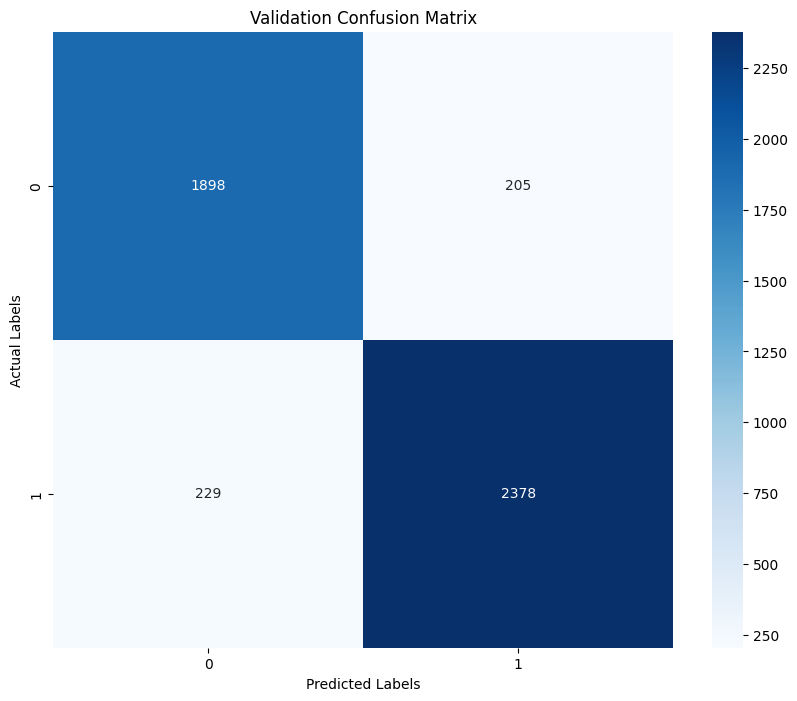

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")


Weighted Precision: 0.9079998214672512
Weighted Recall: 0.9078556263269639
Weighted F1 Score: 0.9079039782305023


In [ ]:
false_negatives = [val_texts[i] for i, (pred, true) in enumerate(zip(val_preds, val_labels)) if pred == 0 and true == 1]
false_positives = [val_texts[i] for i, (pred, true) in enumerate(zip(val_preds, val_labels)) if pred == 1 and true == 0]

print("Common False Negatives (sarcasm missed):")
for text in false_negatives[:5]:
    print(text)

print("\nCommon False Positives (non-sarcastic classified as sarcastic):")
for text in false_positives[:5]:
    print(text)


Common False Negatives (sarcasm missed):
hell yes were the best lol i sent u mine save it k
the tomatoes could not be better but when in a shipment of cans a third of the cans are somewhat dented and another third seriously dented there is obviously an issue that needs to be addressed 
you should ve hit them they want to park there then make it legit ha speaking as a disabled person myself
today food shopping italian market bbqing in the afternoon and chilling in the sun could be worse
sooo much easier to give medication to now i used to feel like a jerk forcing medicine down her throat 

Common False Positives (non-sarcastic classified as sarcastic):
my kids are very disappointed that i no longer buy ovaltine it costs more there is less product more sugar and less nutrients i have boys and i started my oldest who is now on ovaltine ever since he started on milk it was great to have something for him that i could count on for nutrients when he was a pickyeater now we are no longer an o

In [ ]:
from sklearn.metrics import f1_score

class_f1_scores = f1_score(val_labels, val_preds, average=None)
print(f"Class-wise F1-Scores: {class_f1_scores}")


Class-wise F1-Scores: [0.89739953 0.91637765]


In [ ]:
def eval_model(model, data_loader, device, criterion):
    model = model.eval()
    val_loss = 0
    correct_predictions = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Collect predictions and true labels
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            correct_predictions += torch.sum(preds == labels).item()  # Ensure it's a Python number

    # Calculate accuracy as a float
    val_accuracy = correct_predictions / len(data_loader.dataset)  # This is now a float

    return val_loss / len(data_loader), float(val_accuracy), val_preds, val_labels  # Ensure val_accuracy is a float


In [ ]:
val_loss, val_accuracy, val_preds, val_labels = eval_model(model, val_loader, device, criterion)

In [ ]:
# Verify lengths before plotting
#print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of val_losses: {len(val_preds)}")
print(f"Length of val_accuracies: {len(val_labels)}")


Length of val_losses: 4710
Length of val_accuracies: 4710


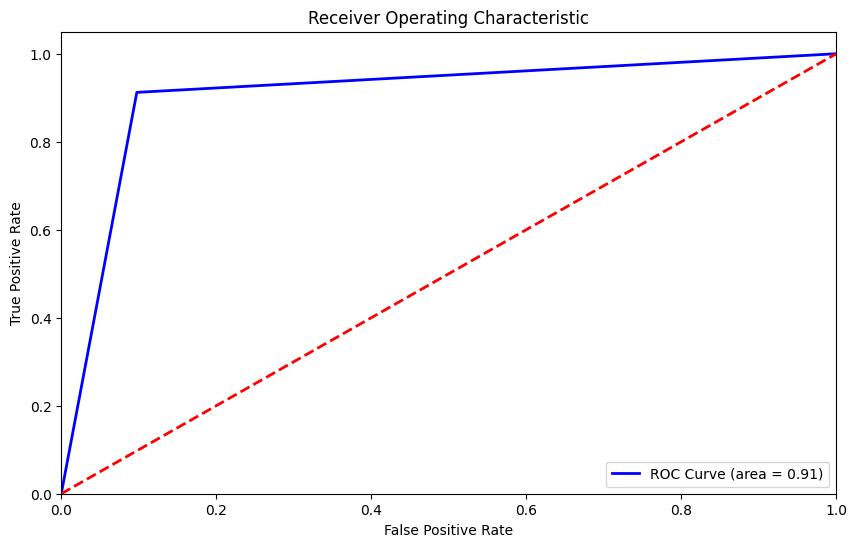

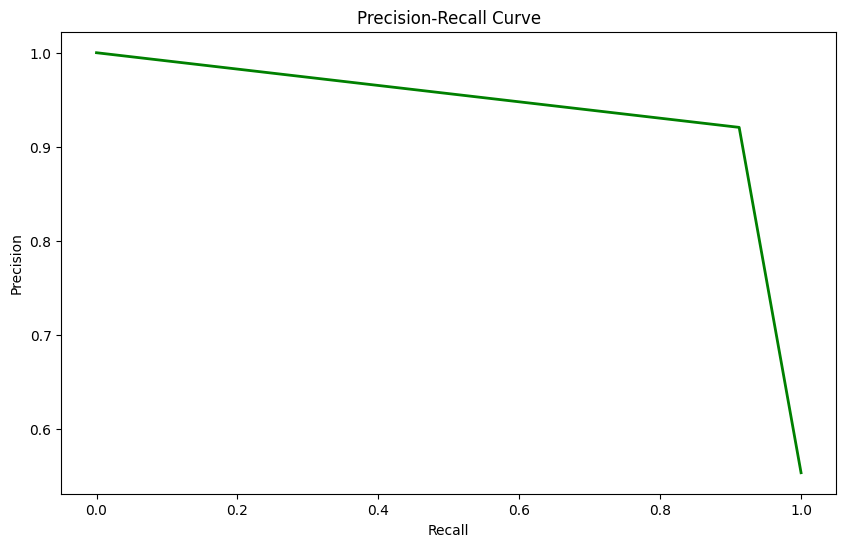

In [ ]:
# 2. ROC Curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# 3. Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predictions):
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Assuming your final validation predictions are in val_preds and true_labels
# Convert val_preds to probabilities if necessary (e.g., for binary classification)
val_preds_probs = [1 if pred == 1 else 0 for pred in val_preds]  # Modify based on your model's output

# Plotting ROC and Precision-Recall curves
plot_roc_curve(val_labels, val_preds_probs)
plot_precision_recall_curve(val_labels, val_preds_probs)


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

# Extracting features and labels including attention mask
def extract_val_data(val_loader):
    X_val = []
    attention_masks = []
    y_val = []
    for data in val_loader:
        input_ids = data['input_ids']  # Replace with your actual input features
        attention_mask = data['attention_mask']
        labels = data['labels'].numpy()

        X_val.append(input_ids.cpu().numpy())  # Assuming input_ids is a tensor
        attention_masks.append(attention_mask.cpu().numpy())  # Assuming attention_mask is a tensor
        y_val.append(labels)

    return np.concatenate(X_val), np.concatenate(attention_masks), np.concatenate(y_val)

# Get validation data
X_val, attention_masks, y_val = extract_val_data(val_loader)

# Assuming you have already made predictions with your model
# y_pred = model.predict(X_val)  # Or however you obtain your predictions
# If you use PyTorch:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_val).to(device)  # Move to device if needed
    masks = torch.tensor(attention_masks).to(device)  # Move attention masks to device

    # Pass both input_ids and attention_mask to the model
    outputs = model(input_ids=inputs, attention_mask=masks)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.cpu().numpy()  # Convert to NumPy for further processing

# Continue with the rest of your code...


# 1. Permutation Importance
def plot_permutation_importance(model, X_val, y_val):
    result = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], yerr=result.importances_std[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])  # Adjust for DataFrame or array
    plt.title("Permutation Importance")
    plt.xlabel("Importance Score")
    plt.show()

# Example call:
plot_permutation_importance(model, X_val, y_val)

# 2. Class Distribution
def plot_class_distribution(y):
    sns.countplot(x=y)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Example call:
plot_class_distribution(y_val)

# 3. Misclassification Plots
def plot_misclassified_samples(X_val, y_val, y_pred, n_samples=10):
    misclassified_idx = np.where(y_val != y_pred)[0]
    if len(misclassified_idx) == 0:
        print("No misclassifications found.")
        return

    # Select a few misclassified samples
    np.random.shuffle(misclassified_idx)
    misclassified_idx = misclassified_idx[:n_samples]

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_idx):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(X_val[idx], cmap='gray')  # Adjust based on your data format
        plt.title(f'True: {y_val[idx]}\nPredicted: {y_pred[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example call:
plot_misclassified_samples(X_val, y_val, y_pred)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.73 GiB. GPU 0 has a total capacity of 15.89 GiB of which 1.68 GiB is free. Process 2657 has 14.21 GiB memory in use. Of the allocated memory 11.42 GiB is allocated by PyTorch, and 2.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


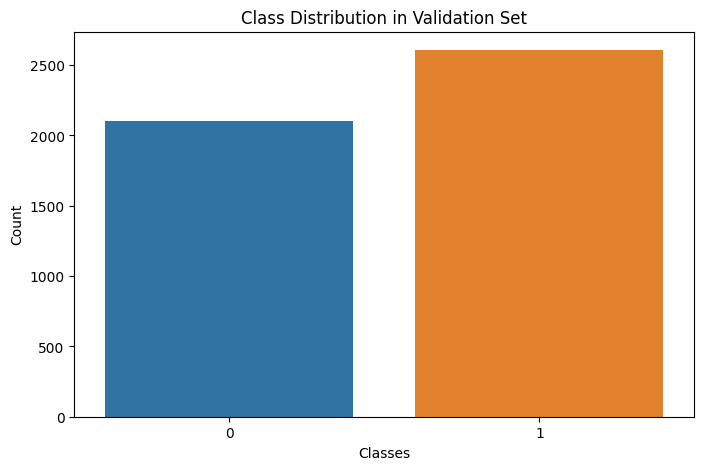

Misclassifications:
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 0, Predicted: 1
True: 0, Predicted: 1


In [ ]:
def plot_class_distribution(true_labels):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=true_labels)
    plt.title('Class Distribution in Validation Set')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

# Call the function
plot_class_distribution(val_labels)

# Analyzing Misclassifications
def analyze_misclassifications(true_labels, val_preds):
    misclassified = [(true, pred) for true, pred in zip(true_labels, val_preds) if true != pred]
    print("Misclassifications:")
    for true, pred in misclassified[:10]:  # Print the first 10 misclassifications
        print(f"True: {true}, Predicted: {pred}")

# Call the function
analyze_misclassifications(val_labels, val_preds)


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming val_labels and n_classes are already defined
true_labels_bin = label_binarize(val_labels, classes=np.arange(2))
print(true_labels_bin.shape)  # Should be (n_samples, n_classes)
print(np.unique(val_labels))  # Should show more than one class


(4710, 1)
[0 1]


In [ ]:
print(X_val[0].shape)


(128,)


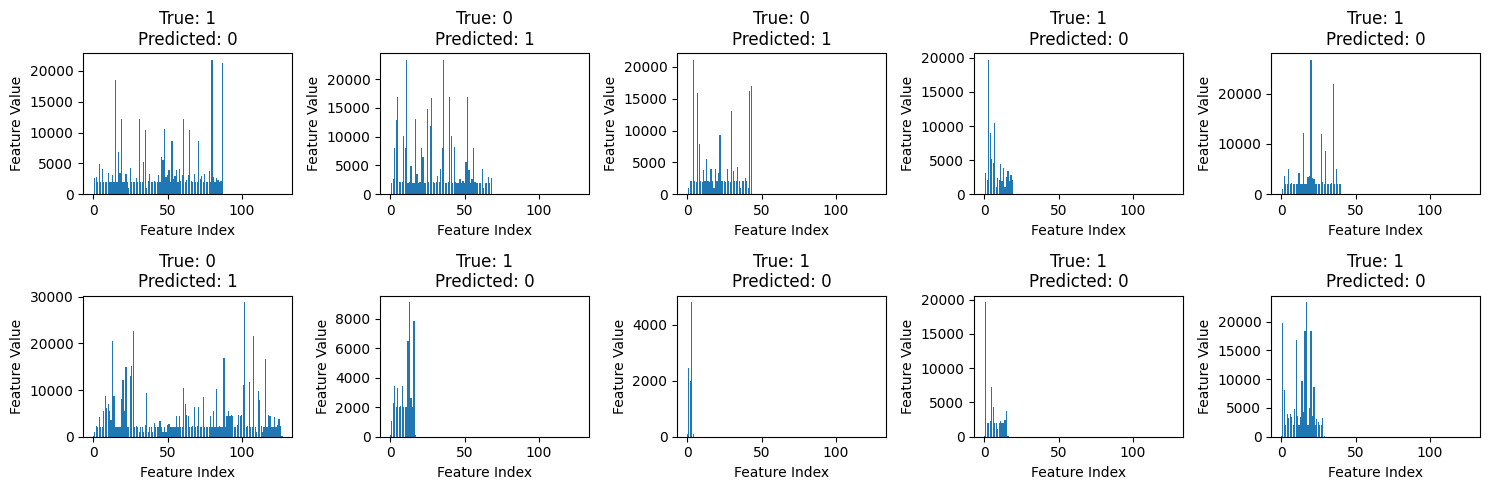

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_misclassified_samples(X_val, y_val, y_pred, n_samples=10):
    # Ensure y_val and y_pred are at least 1D arrays
    y_val = np.atleast_1d(y_val)
    y_pred = np.atleast_1d(y_pred)

    misclassified_idx = np.where(y_val != y_pred)[0]
    if len(misclassified_idx) == 0:
        print("No misclassifications found.")
        return

    # Select a few misclassified samples
    np.random.shuffle(misclassified_idx)
    misclassified_idx = misclassified_idx[:n_samples]

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_idx):
        plt.subplot(2, n_samples // 2, i + 1)

        # Plot the feature vector as a bar chart
        plt.bar(range(len(X_val[idx])), X_val[idx])  # X_val[idx] is a feature vector
        plt.title(f'True: {y_val[idx]}\nPredicted: {y_pred[idx]}')
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Value')
    plt.tight_layout()
    plt.show()

# Example call:
plot_misclassified_samples(X_val, val_labels, val_preds)


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Plot ROC curve for binary classification
def plot_roc_curve_binary(true_labels, val_preds_probs):
    fpr, tpr, _ = roc_curve(true_labels, val_preds_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Binary Classification')
    plt.legend(loc='lower right')
    plt.show()

# Plot Precision-Recall curve for binary classification
def plot_precision_recall_curve_binary(true_labels, val_preds_probs):
    precision, recall, _ = precision_recall_curve(true_labels, val_preds_probs)

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Binary Classification')
    plt.show()

# Assuming true_labels and val_preds_probs are 1D arrays (binary classification)
plot_roc_curve_binary(val_labels, val_preds_probs)
plot_precision_recall_curve_binary(val_labels, val_preds_probs)


ValueError: y should be a 1d array, got an array of shape (4710, 2) instead.

In [ ]:
# 1. Permutation Importance
def plot_permutation_importance(model, X_val, y_val):
    result = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], yerr=result.importances_std[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])  # Adjust for DataFrame or array
    plt.title("Permutation Importance")
    plt.xlabel("Importance Score")
    plt.show()

# Example call:
plot_permutation_importance(model, X_val, y_val)

TypeError: estimator should be an estimator implementing 'fit' method, DoubleBERT(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (bert_classifier): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=1536, out_features=2, bias=True)
) was passed

In [ ]:
def top_k_accuracy(val_preds, val_labels, k=3):
    top_k_correct = 0
    total_samples = len(val_labels)

    # Convert to numpy for ease of processing
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)

    for i in range(total_samples):
        top_k_pred = np.argsort(val_preds[i])[-k:]  # Get top K predictions
        if val_labels[i] in top_k_pred:
            top_k_correct += 1

    top_k_acc = top_k_correct / total_samples
    print(f"Top-{k} Accuracy: {top_k_acc:.2f}")

# Call the function (for example, top-3 accuracy)
top_k_accuracy(val_preds, val_labels, k=3)


Top-3 Accuracy: 0.45


In [ ]:
from sklearn.metrics import accuracy_score
class_names=['sacasm', 'non']
def per_class_accuracy(val_labels, val_preds, class_names):
    class_accuracies = {}

    for class_idx, class_name in enumerate(class_names):
        class_labels = [1 if label == class_idx else 0 for label in val_labels]
        class_preds = [1 if pred == class_idx else 0 for pred in val_preds]
        class_accuracy = accuracy_score(class_labels, class_preds)
        class_accuracies[class_name] = class_accuracy

    print("Per-Class Accuracy:")
    for class_name, accuracy in class_accuracies.items():
        print(f"Class '{class_name}': {accuracy:.2f}")

# Assuming class_names is a list of class labels (e.g., ['Class 0', 'Class 1', 'Class 2'])
per_class_accuracy(val_labels, val_preds, class_names)


Per-Class Accuracy:
Class 'sacasm': 0.90
Class 'non': 0.90


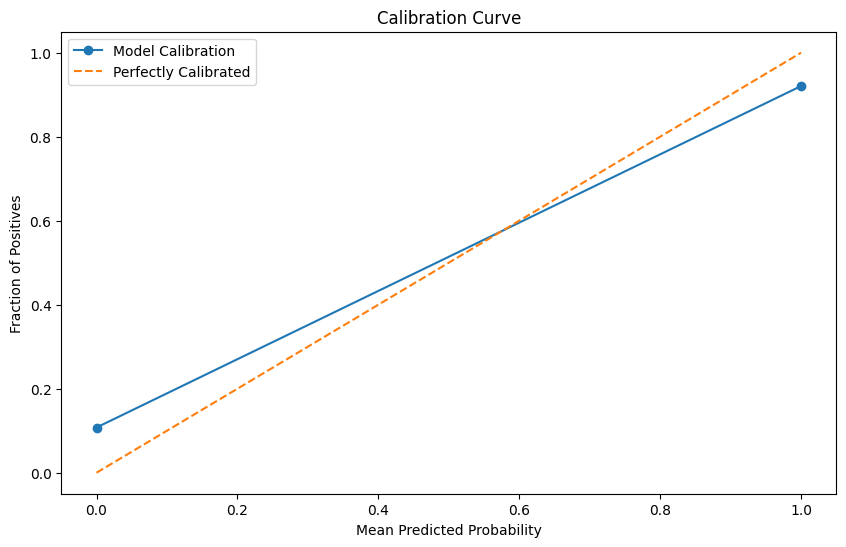

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(val_labels, val_preds_probs, n_bins=10):
    plt.figure(figsize=(10, 6))

    # Get calibration curve
    prob_true, prob_pred = calibration_curve(val_labels, val_preds_probs, n_bins=n_bins)

    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

    plt.title('Calibration Curve')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.show()

# Assuming val_preds_probs are the predicted probabilities for the positive class
plot_calibration_curve(val_labels, val_preds_probs)


In [ ]:
from sklearn.metrics import log_loss

def calculate_log_loss(val_labels, val_preds_probs):
    loss = log_loss(val_labels, val_preds_probs)
    print(f"Log Loss: {loss:.2f}")

# Assuming val_preds_probs contains the predicted probabilities
calculate_log_loss(val_labels, val_preds_probs)


Log Loss: 3.32


In [ ]:
import torch.nn.functional as F

def eval_model(model, data_loader, device, criterion):
    model = model.eval()
    val_loss = 0
    correct_predictions = 0
    val_preds = []
    val_labels = []
    val_preds_probs = []  # List to hold predicted probabilities

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Collect predictions and true labels
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            # Calculate probabilities using softmax
            probs = F.softmax(outputs, dim=1)  # Apply softmax to the output
            val_preds_probs.extend(probs.cpu().numpy())  # Collect predicted probabilities

            correct_predictions += torch.sum(preds == labels)

    # Calculate accuracy
    val_accuracy = correct_predictions.double() / len(data_loader.dataset)

    return val_loss / len(data_loader), val_accuracy, val_preds, val_labels, np.array(val_preds_probs)  # Return probabilities



Epoch 1/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0149
Validation Loss: 0.5661
Validation Accuracy: 0.9045
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2103
           1       0.93      0.90      0.91      2607

    accuracy                           0.90      4710
   macro avg       0.90      0.91      0.90      4710
weighted avg       0.91      0.90      0.90      4710

Log Loss: 0.5582
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.90
Class 'Class 1': 0.90


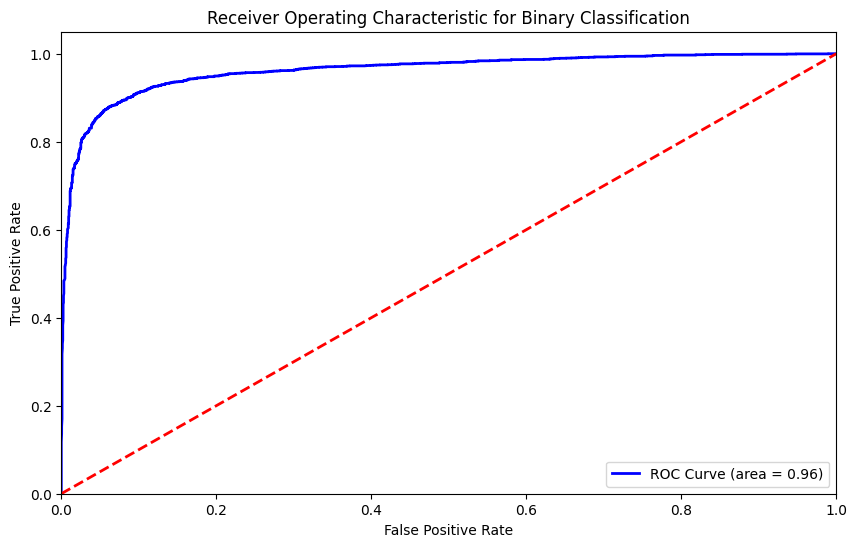

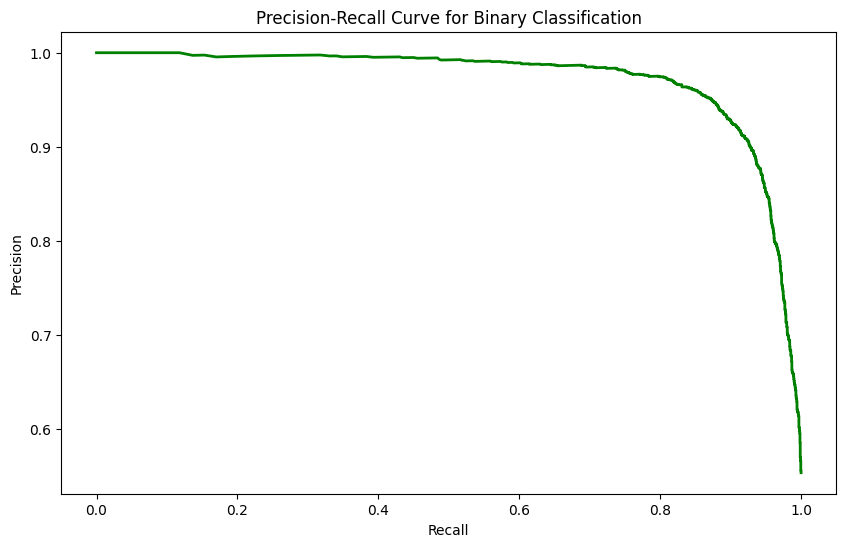

Model checkpoint saved.

Epoch 2/10
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0060
Validation Loss: 0.6675
Validation Accuracy: 0.9051
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.90      0.90      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.6575
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


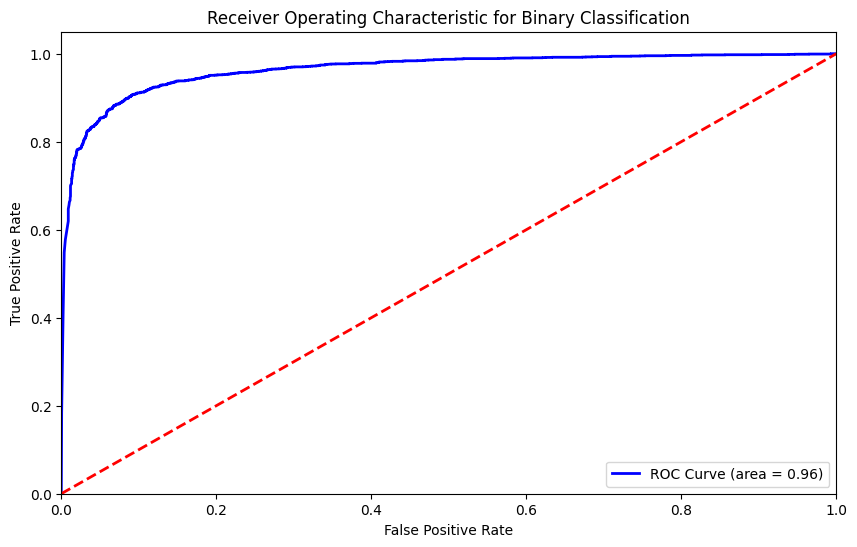

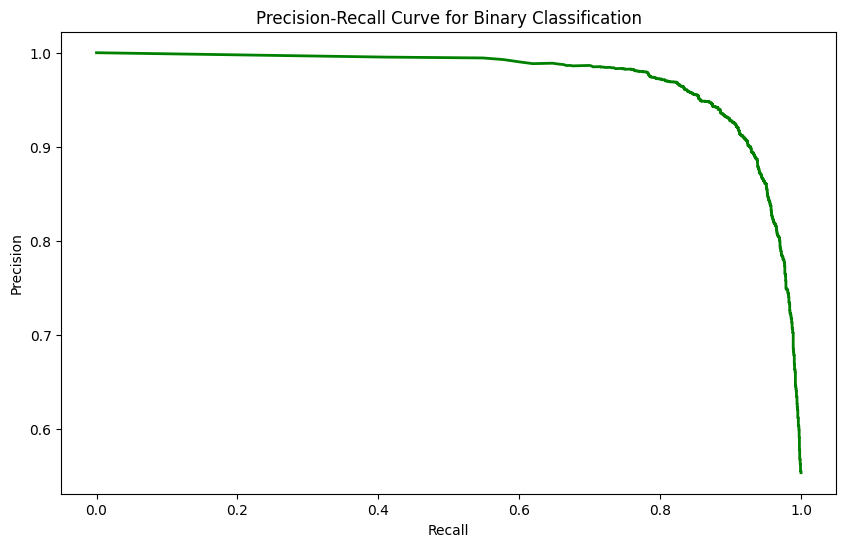

Model checkpoint saved.

Epoch 3/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0023
Validation Loss: 0.6915
Validation Accuracy: 0.9040
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2103
           1       0.92      0.90      0.91      2607

    accuracy                           0.90      4710
   macro avg       0.90      0.90      0.90      4710
weighted avg       0.90      0.90      0.90      4710

Log Loss: 0.6798
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.90
Class 'Class 1': 0.90


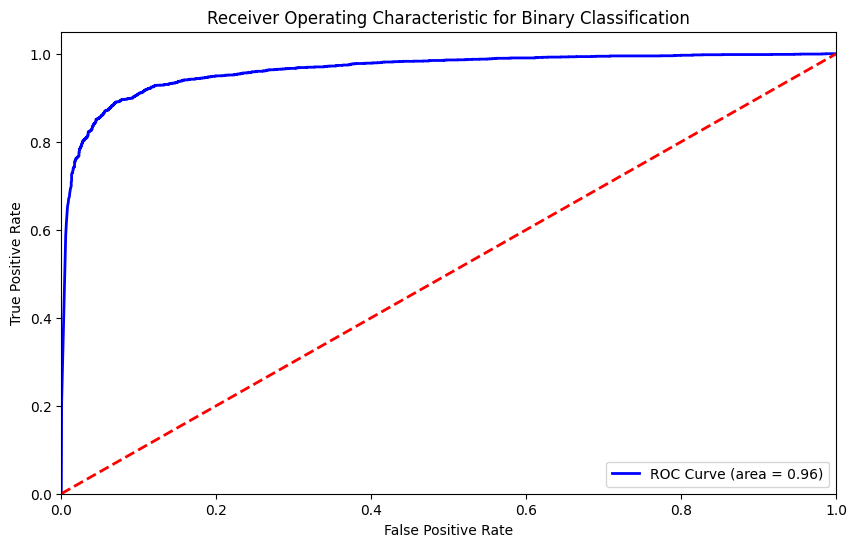

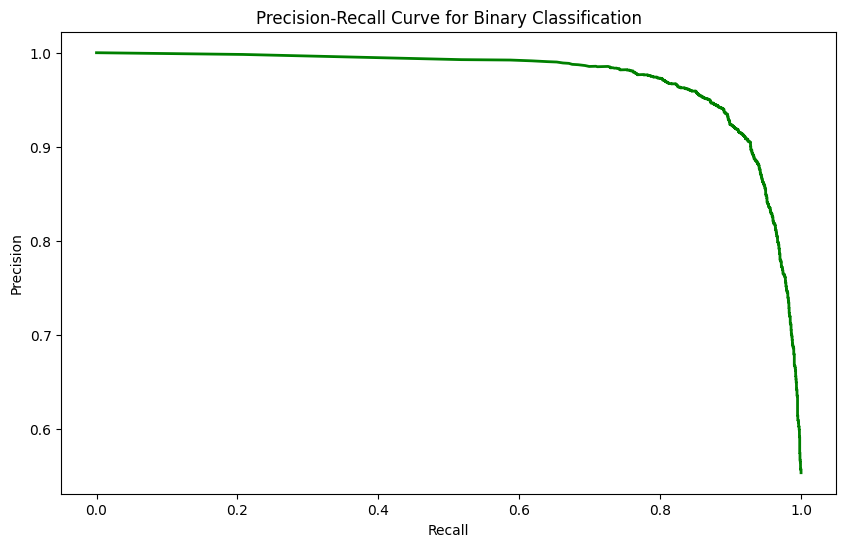


Epoch 4/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0016
Validation Loss: 0.7031
Validation Accuracy: 0.9057
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.90      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.6915
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


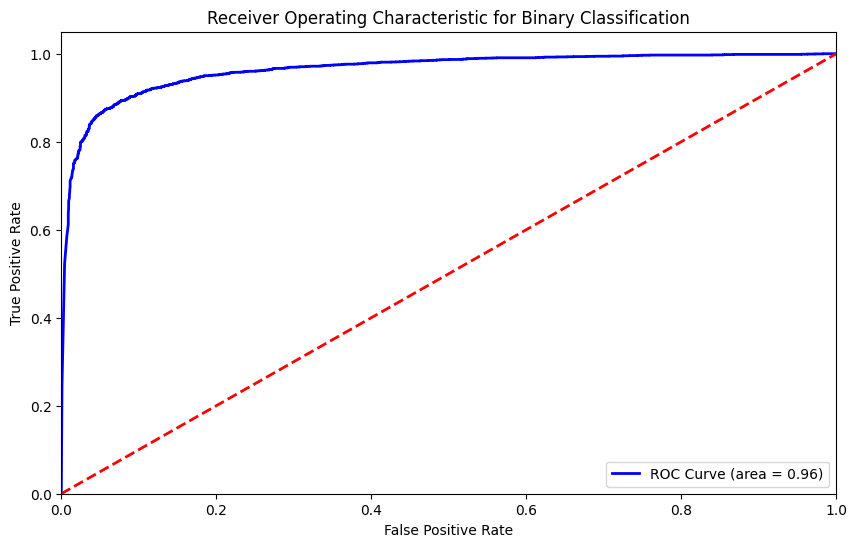

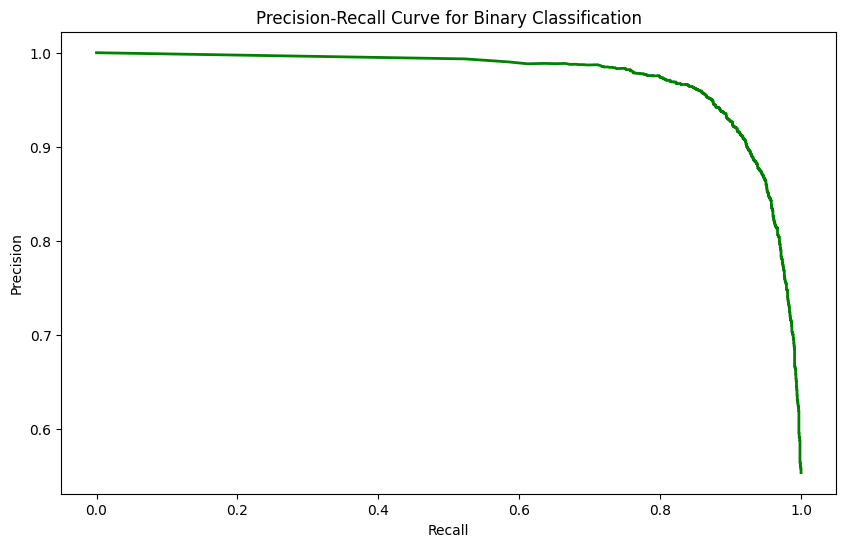

Model checkpoint saved.

Epoch 5/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0010
Validation Loss: 0.7276
Validation Accuracy: 0.9070
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.92      2607

    accuracy                           0.91      4710
   macro avg       0.91      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7152
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


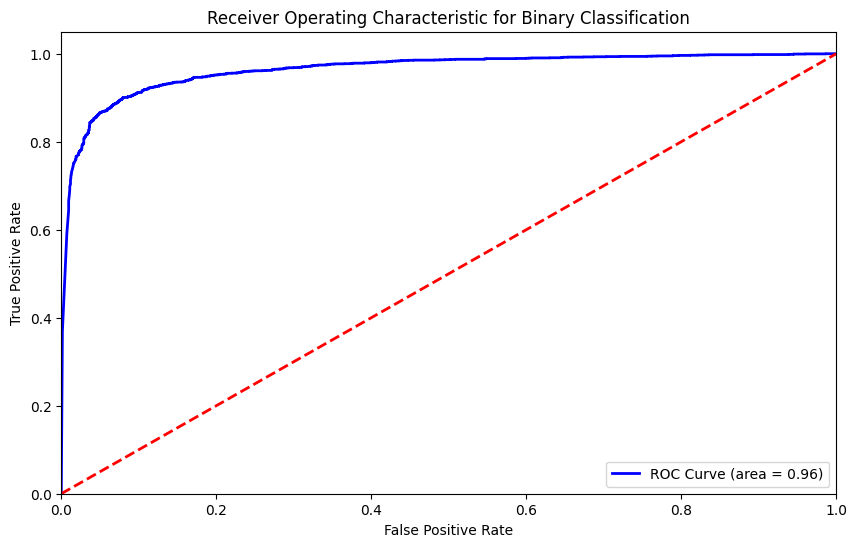

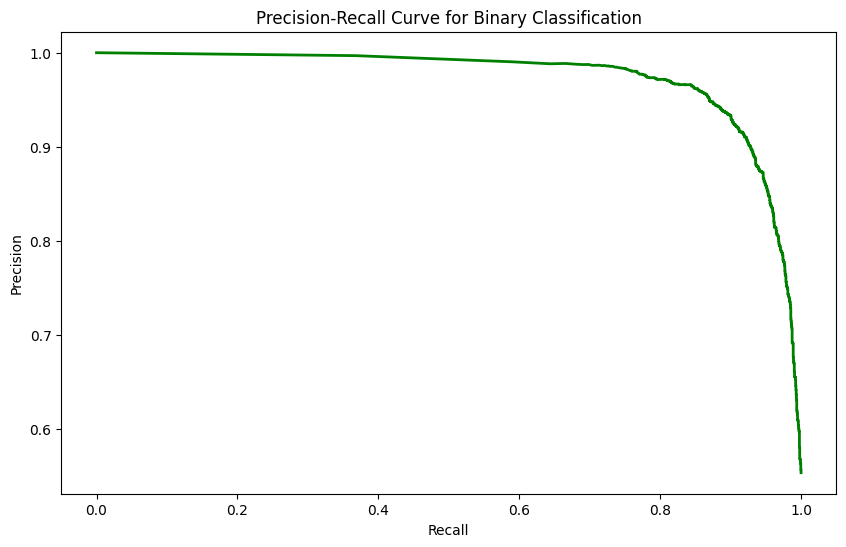

Model checkpoint saved.

Epoch 6/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0006
Validation Loss: 0.7278
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7148
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


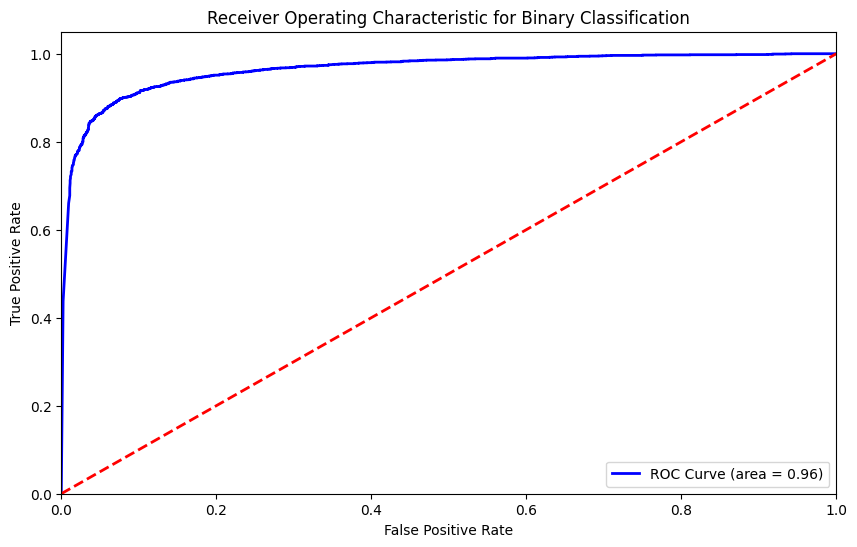

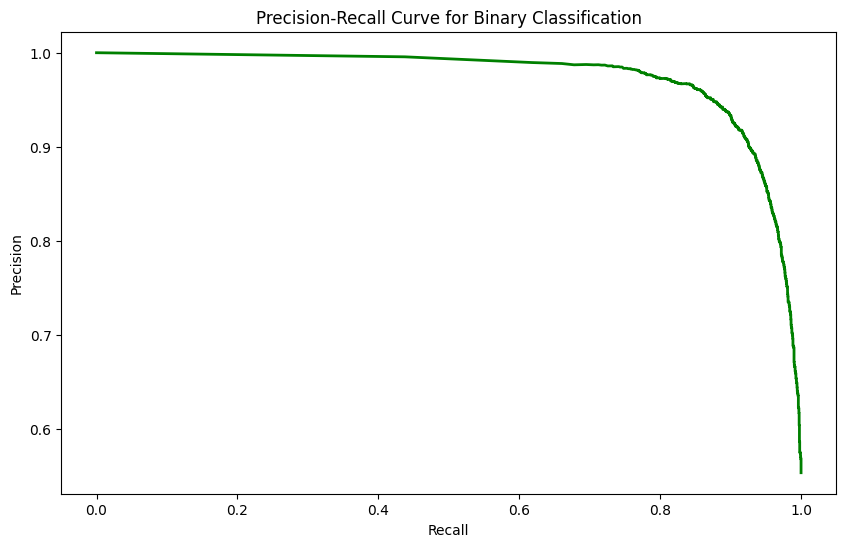


Epoch 7/10
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0004
Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7208
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


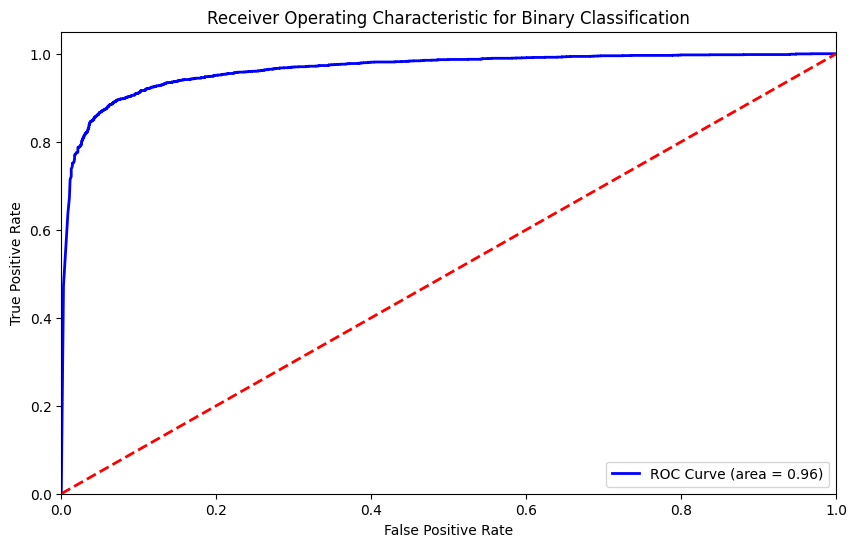

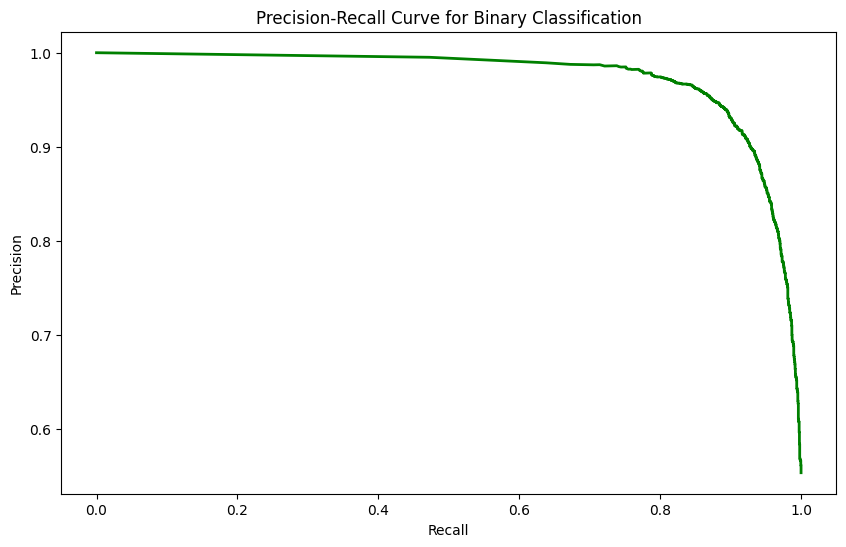


Epoch 8/10
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0003
Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7208
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


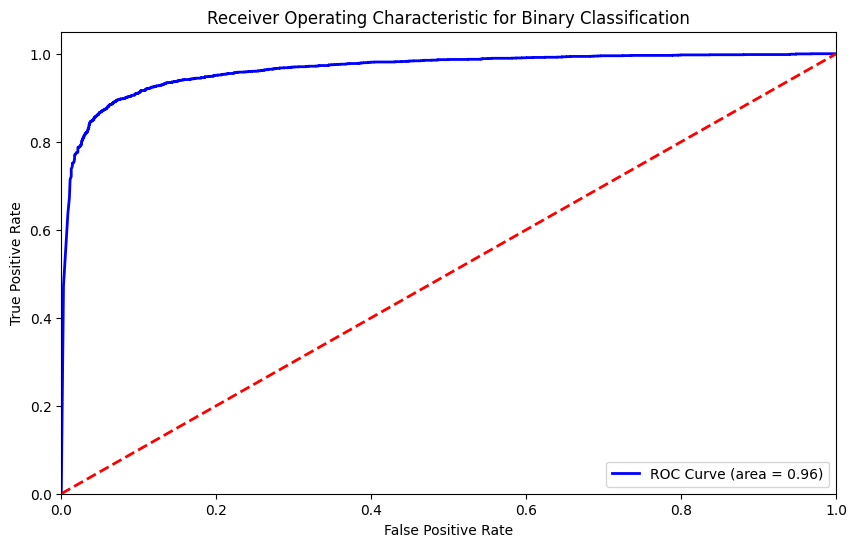

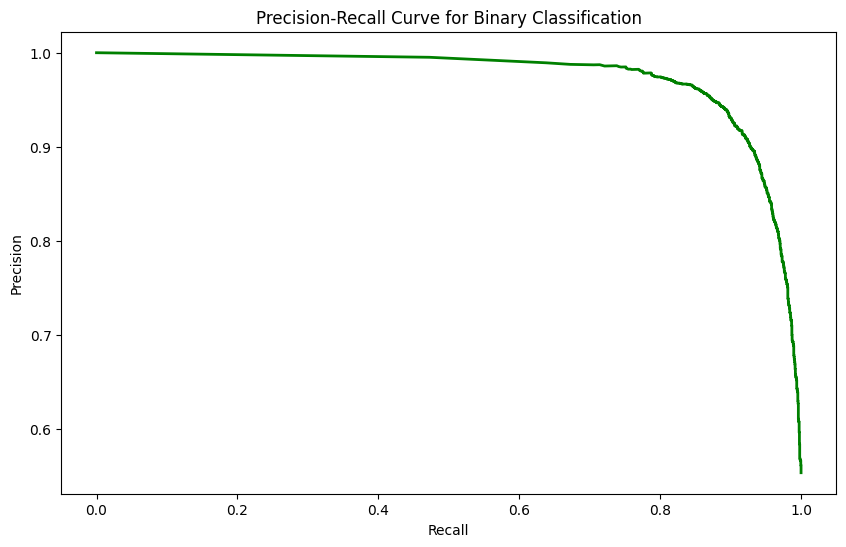


Epoch 9/10
--------------------


Training: 100%|██████████| 589/589 [11:57<00:00,  1.22s/it]


Training Loss: 0.0004
Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7208
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


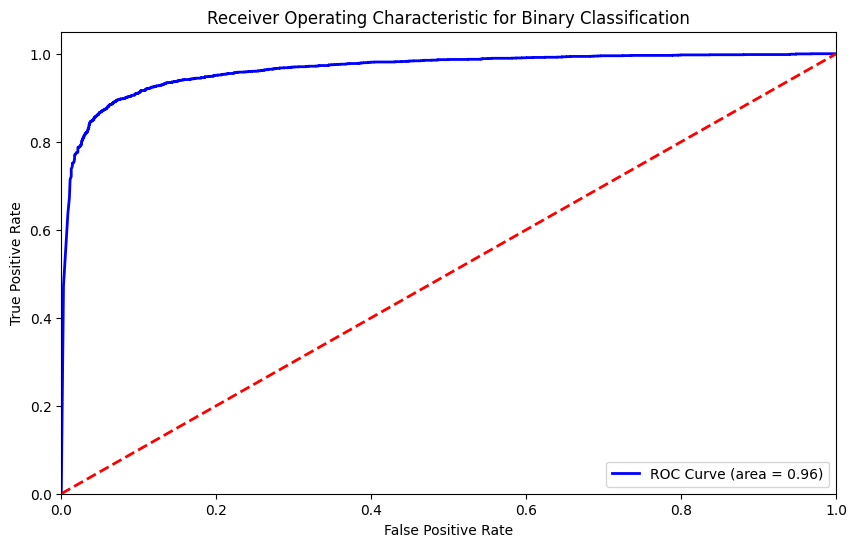

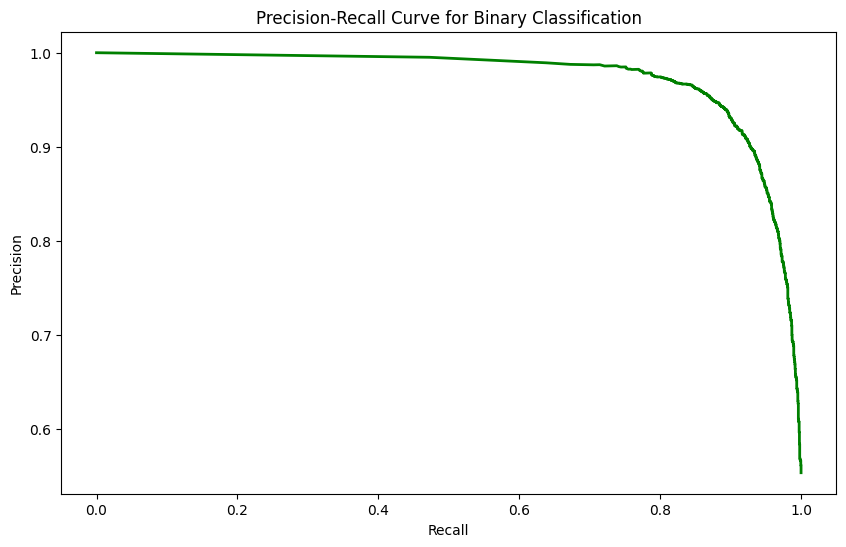


Epoch 10/10
--------------------


Training: 100%|██████████| 589/589 [11:56<00:00,  1.22s/it]


Training Loss: 0.0003
Validation Loss: 0.7344
Validation Accuracy: 0.9064
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2103
           1       0.92      0.91      0.91      2607

    accuracy                           0.91      4710
   macro avg       0.90      0.91      0.91      4710
weighted avg       0.91      0.91      0.91      4710

Log Loss: 0.7208
Top-3 Accuracy: 0.45
Per-Class Accuracy:
Class 'Class 0': 0.91
Class 'Class 1': 0.91


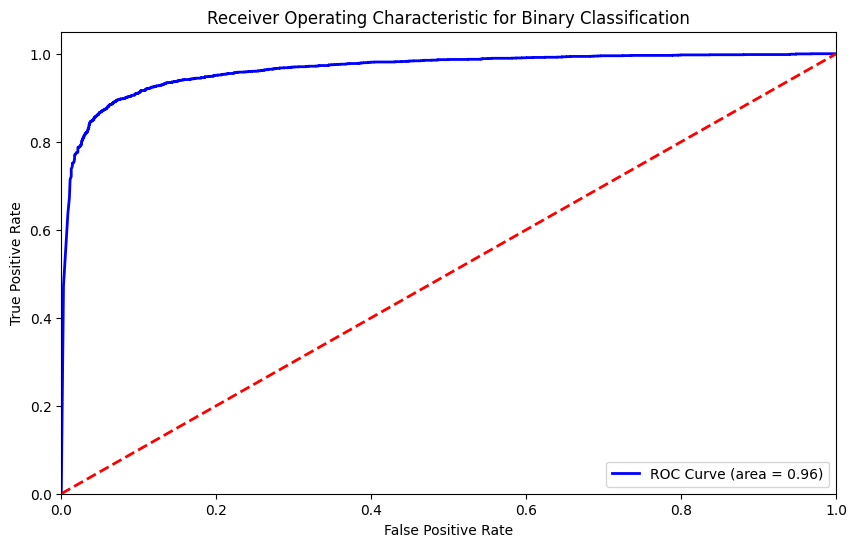

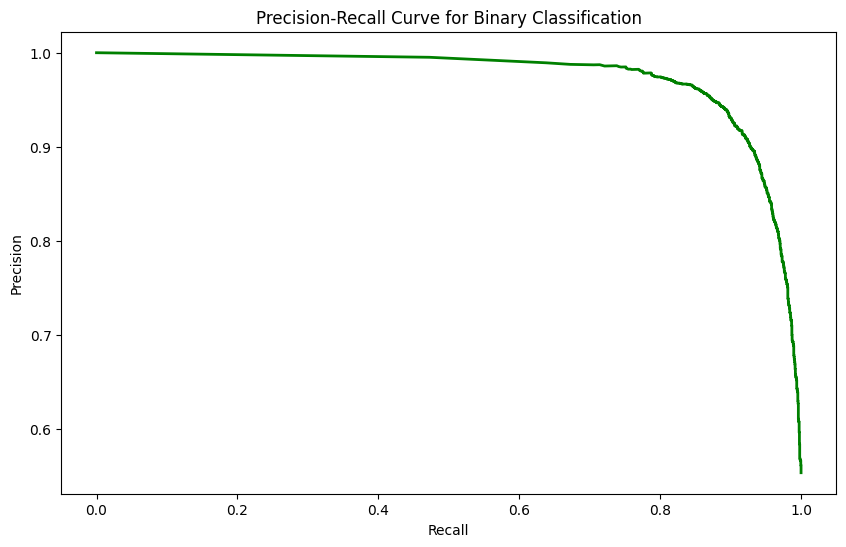

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

class_names=['sacasm', 'non']
# Initialize best validation accuracy before the training loop
best_val_accuracy = 0.0
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 20)

    # Training the model
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, criterion)
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluating the model
    val_loss, val_accuracy, val_preds, val_labels, val_preds_probs = eval_model(model, val_loader, device, criterion)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Generate classification report
    val_report = classification_report(val_labels, val_preds)
    print("Classification Report:")
    print(val_report)

    # Log Loss Calculation
    log_loss_value = log_loss(val_labels, val_preds_probs)
    print(f"Log Loss: {log_loss_value:.4f}")

    # Top-K Accuracy (optional)
    top_k_accuracy(val_preds, val_labels, k=3)

    # Per-Class Accuracy
    class_names = ["Class 0", "Class 1"]  # Update with your actual class names
    per_class_accuracy(val_labels, val_preds, class_names)

    # ROC and Precision-Recall Curve plotting
    plot_roc_curve_binary(val_labels, val_preds_probs[:, 1])  # Adjust for binary/multiclass
    plot_precision_recall_curve_binary(val_labels, val_preds_probs[:, 1])

    # Checkpointing the model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("Model checkpoint saved.")

    # Optionally, you can store training and validation losses for later plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)


[0.014908793844061113, 0.005951236404463492, 0.002282518541113641, 0.0016341419907198057, 0.0010135171329599356, 0.0005932052772646886, 0.0003607580382304582, 0.0002673946809961658, 0.00035234217738195424, 0.00026172384268057246]
[0.5660973559247764, 0.6675385726754226, 0.6914848895280188, 0.7030743796562633, 0.7275778966021347, 0.7278324984778206, 0.7344102896827157, 0.7344102896827157, 0.7344102896827157, 0.7344102896827157]


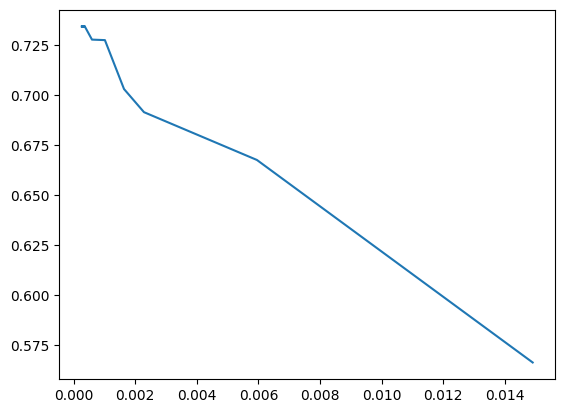

In [ ]:
print(train_losses)
print(val_losses)


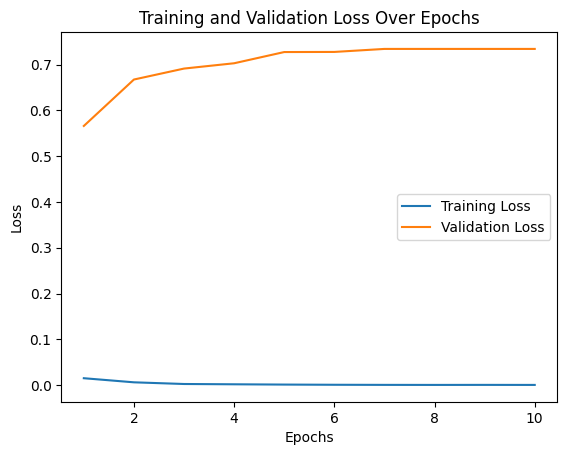

In [ ]:
import matplotlib.pyplot as plt

# Loss values
train_losses = [0.014908793844061113, 0.005951236404463492, 0.002282518541113641, 0.0016341419907198057, 0.0010135171329599356, 0.0005932052772646886, 0.0003607580382304582, 0.0002673946809961658, 0.00035234217738195424, 0.00026172384268057246]
val_losses = [0.5660973559247764, 0.6675385726754226, 0.6914848895280188, 0.7030743796562633, 0.7275778966021347, 0.7278324984778206, 0.7344102896827157, 0.7344102896827157, 0.7344102896827157, 0.7344102896827157]

# Plotting the graph
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()


In [ ]:
def test_sarcasm_detection(model, test_cases):
    results = []
    for case in test_cases:
        prediction = model.predict(case)  # Replace with actual prediction logic
        results.append((case, prediction))
    return results

# Define your test cases
sarcasm_test_cases = [
    "Oh great! Another rainy day. Just what I needed!",
    "What a beautiful day!",  # Contextual
    "I can't believe how wonderfully you handled that mess!",
    "Sure, I'll definitely get right on that.",
    "Thanks for the unsolicited advice, I’ll be sure to use it wisely.",
]

# Call the function
test_results = test_sarcasm_detection(model, sarcasm_test_cases)

# Print results
for case, prediction in test_results:
    print(f"Test Case: '{case}' - Prediction: {prediction}")


AttributeError: 'DoubleBERT' object has no attribute 'predict'

In [ ]:
# Sarcasm test cases with diverse sarcasm types, including your additional samples
sarcasm_test_cases = [
    # Additional examples
    {"text": "Oh great! Another rainy day. Just what I needed!", "description": "Contextual Understanding"},
    {"text": "What a beautiful day!", "description": "Contextual Understanding"},
    {"text": "I can't believe how wonderfully you handled that mess!", "description": "Nuanced Interpretation"},
    {"text": "Sure, I'll definitely get right on that.", "description": "Ambiguous Statements"},
    {"text": "Thanks for the unsolicited advice, I’ll be sure to use it wisely.", "description": "Nuanced Interpretation"},

    # Existing examples
    {"text": "You really nailed that presentation, didn’t you?", "description": "Linguistic and Cultural Variability"},
    {"text": "I just love waiting in long lines at the DMV. It’s the highlight of my week!", "description": "Nuanced Interpretation"},
    {"text": "Wow, what a fantastic job!", "description": "Ambiguous Statements"},
    {"text": "I’ve told you a million times to clean your room!", "description": "Hyperbole and Exaggeration"},
    {"text": "That’s just lit, fam!", "description": "Slang and Informal Language"},
    {"text": "It’s raining cats and dogs!", "description": "Cross-Cultural Idioms"},
    {"text": "I’m sooo happy for you! 😒", "description": "Role of Emotion"},
]

# Function to predict sarcasm for each case and print the result
def test_sarcasm_cases(cases, model, tokenizer, device):
    for idx, case in enumerate(cases):
        text = case["text"]
        description = case["description"]
        # Assuming predict_sarcasm is a predefined function that returns 1 for sarcasm, 0 otherwise
        prediction = predict_sarcasm(text, model, tokenizer, device)
        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        print(f"Case Study {idx+1}: {description}\nText: '{text}'\nPrediction: {label}\n")

# Test all sarcasm cases
test_sarcasm_cases(sarcasm_test_cases, model, tokenizer, device)


Case Study 1: Contextual Understanding
Text: 'Oh great! Another rainy day. Just what I needed!'
Prediction: Not Sarcastic

Case Study 2: Contextual Understanding
Text: 'What a beautiful day!'
Prediction: Sarcastic

Case Study 3: Nuanced Interpretation
Text: 'I can't believe how wonderfully you handled that mess!'
Prediction: Sarcastic

Case Study 4: Ambiguous Statements
Text: 'Sure, I'll definitely get right on that.'
Prediction: Sarcastic

Case Study 5: Nuanced Interpretation
Text: 'Thanks for the unsolicited advice, I’ll be sure to use it wisely.'
Prediction: Sarcastic

Case Study 6: Linguistic and Cultural Variability
Text: 'You really nailed that presentation, didn’t you?'
Prediction: Sarcastic

Case Study 7: Nuanced Interpretation
Text: 'I just love waiting in long lines at the DMV. It’s the highlight of my week!'
Prediction: Sarcastic

Case Study 8: Ambiguous Statements
Text: 'Wow, what a fantastic job!'
Prediction: Sarcastic

Case Study 9: Hyperbole and Exaggeration
Text: 'I’ve 